In [117]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns
from scipy.stats import shapiro


from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


In [118]:
# zaladowanie danych

tickers = ['AAPL', 'MSFT', 'GOOG', 'NFLX', 'AMZN', 'TSLA']
start_date = '2015-01-01'
end_date = '2025-01-01'

def fetch_data(ticker):
    df = yf.download(ticker, interval='1d', start=start_date, end=end_date)
    df = df[['Close']].copy()
    df.rename(columns={'Close': f'{ticker}_Close'}, inplace=True)
    df.to_csv("data_output.txt", index=False)
    return df

data = fetch_data(tickers[0])
for ticker in tickers[1:]:
    data = data.join(fetch_data(ticker), how='outer')

data.dropna(inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,AAPL_Close,MSFT_Close,GOOG_Close,NFLX_Close,AMZN_Close,TSLA_Close
Ticker,AAPL,MSFT,GOOG,NFLX,AMZN,TSLA
Date,,,,,,
2015-01-02,24.288576,39.998703,26.045294,49.848572,15.4260,14.620667
2015-01-05,23.604338,39.630882,25.502361,47.311428,15.1095,14.006000
2015-01-06,23.606558,39.049198,24.911289,46.501431,14.7645,14.085333
2015-01-07,23.937569,39.545330,24.868610,46.742859,14.9210,14.063333
2015-01-08,24.857302,40.708679,24.947023,47.779999,15.0230,14.041333


Original column structure:

Flattened column names:
AAPL


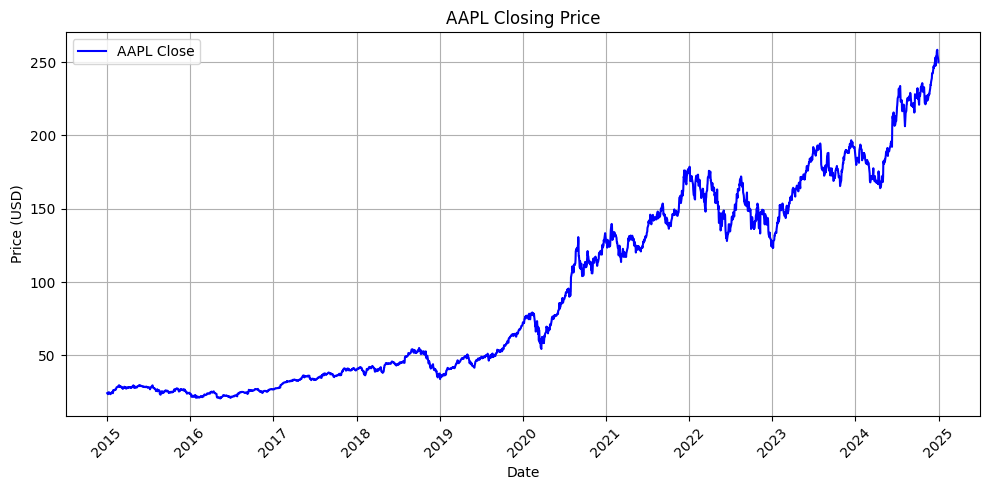

MSFT


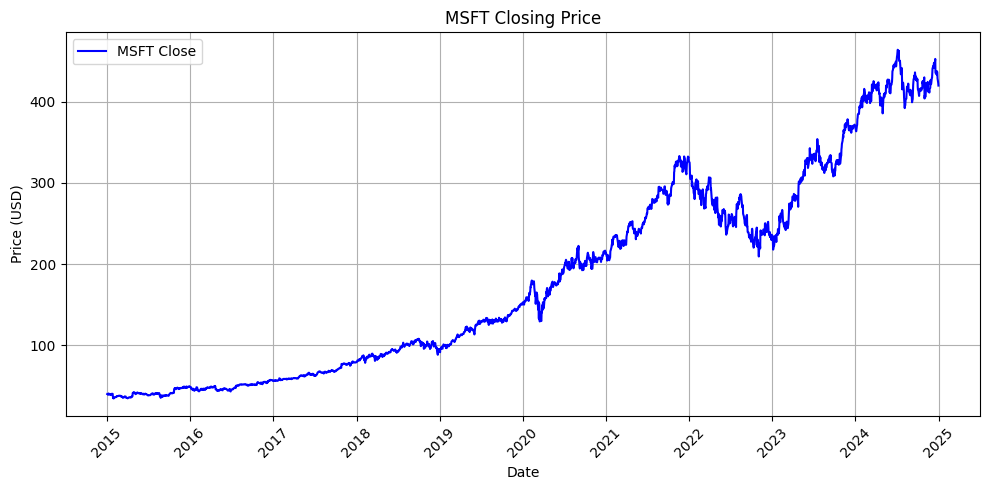

GOOG


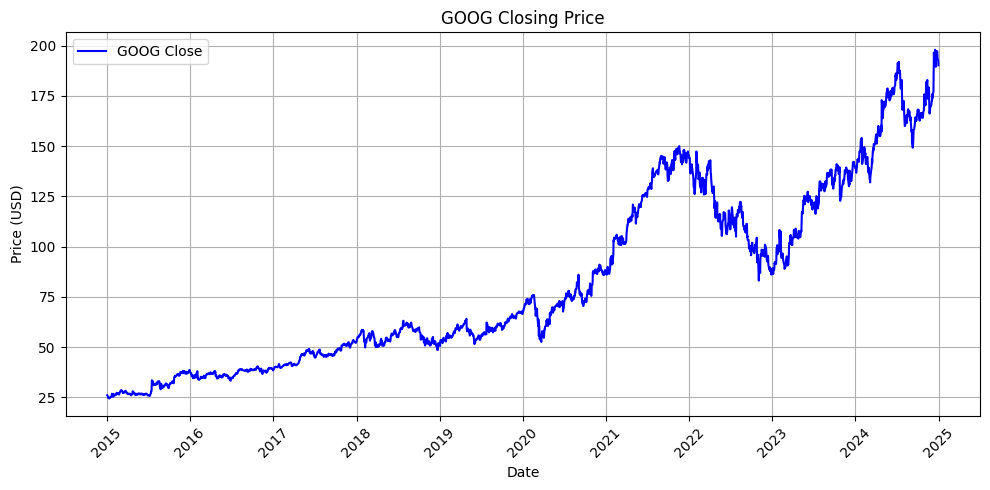

NFLX


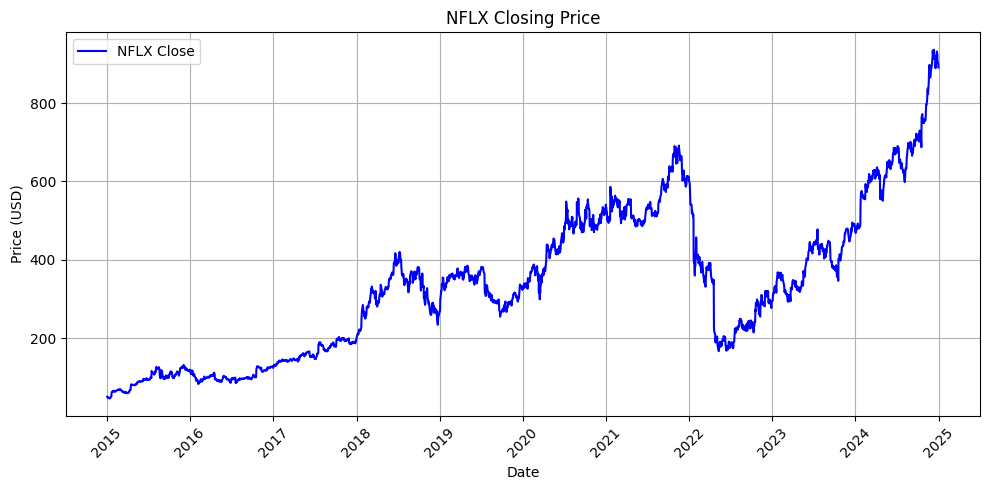

AMZN


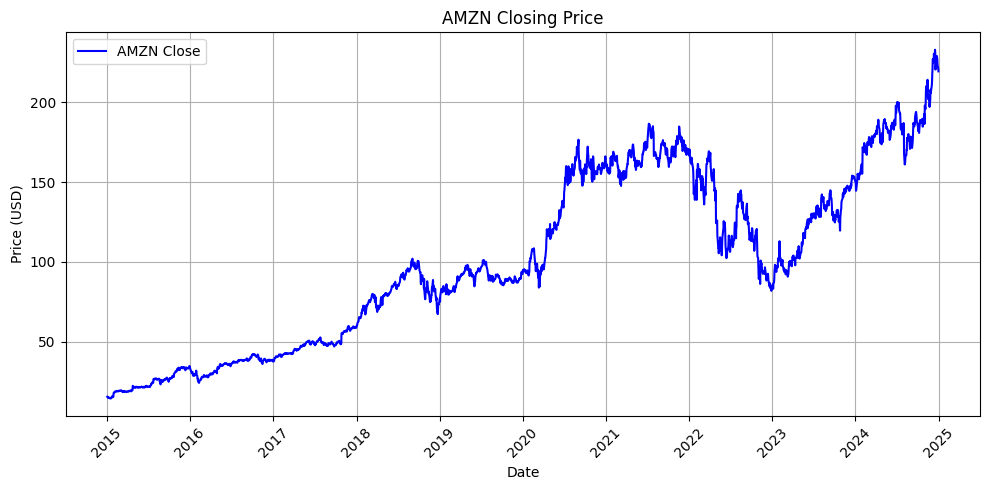

TSLA


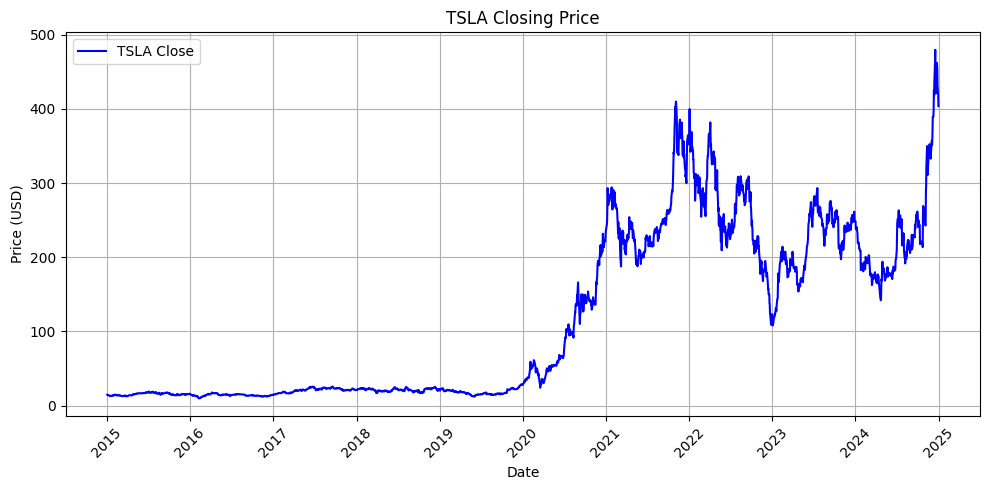

In [119]:
print("Original column structure:")
data.columns

u = data.copy()

data.columns = ['_'.join(col).strip() for col in data.columns.to_flat_index()]

print("\nFlattened column names:")

for ticker, column_name in zip(tickers, data.columns):
    print(ticker)
    
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data[column_name], linestyle='-', color='blue', label=f"{ticker} Close")
    plt.title(f'{ticker} Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

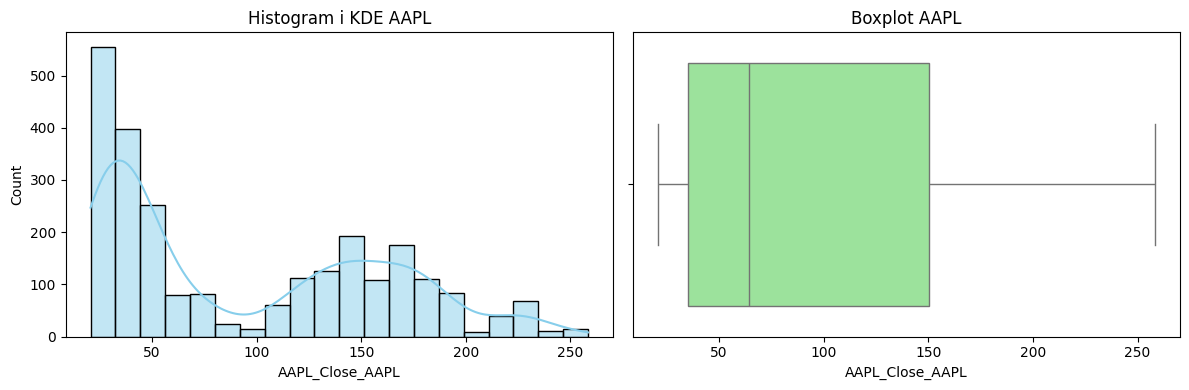

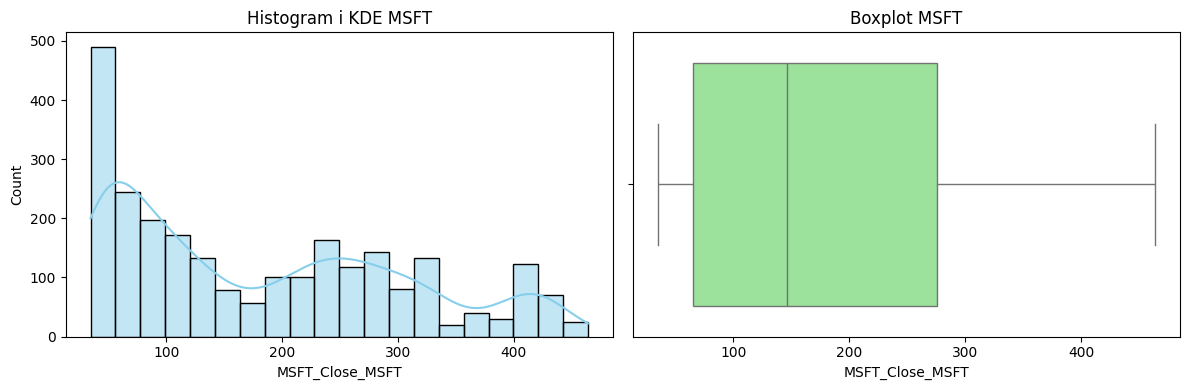

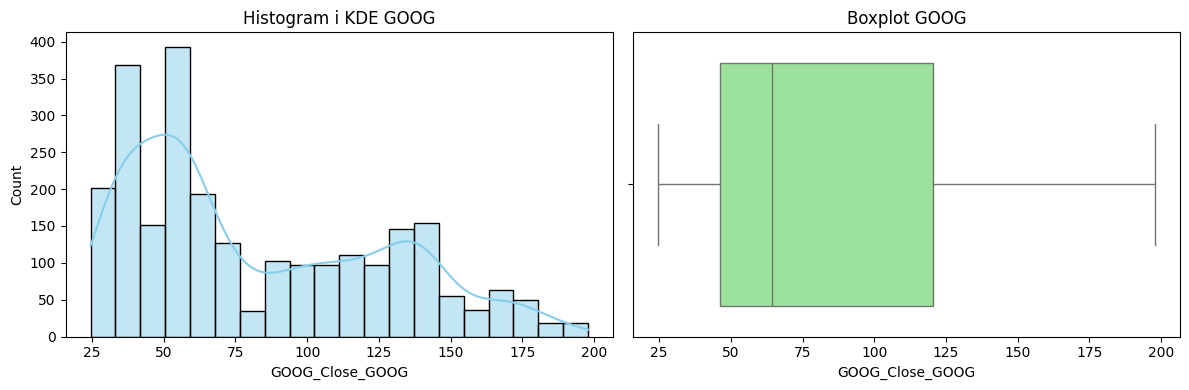

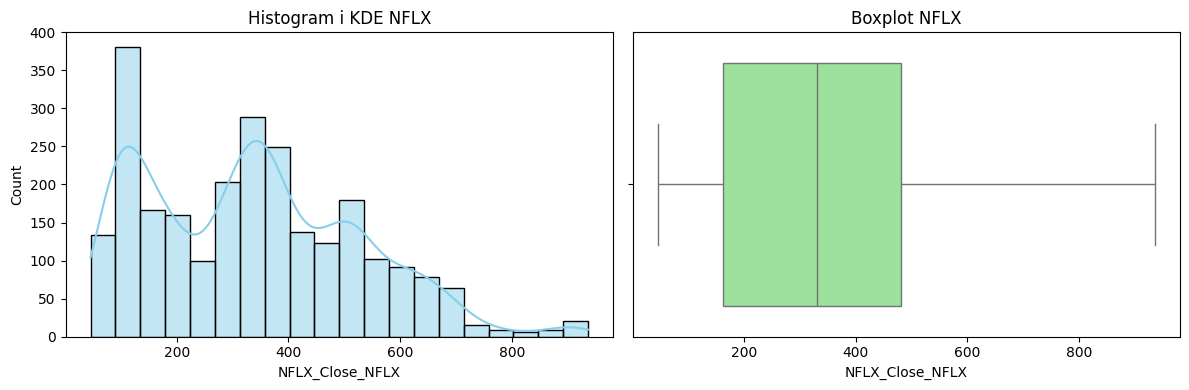

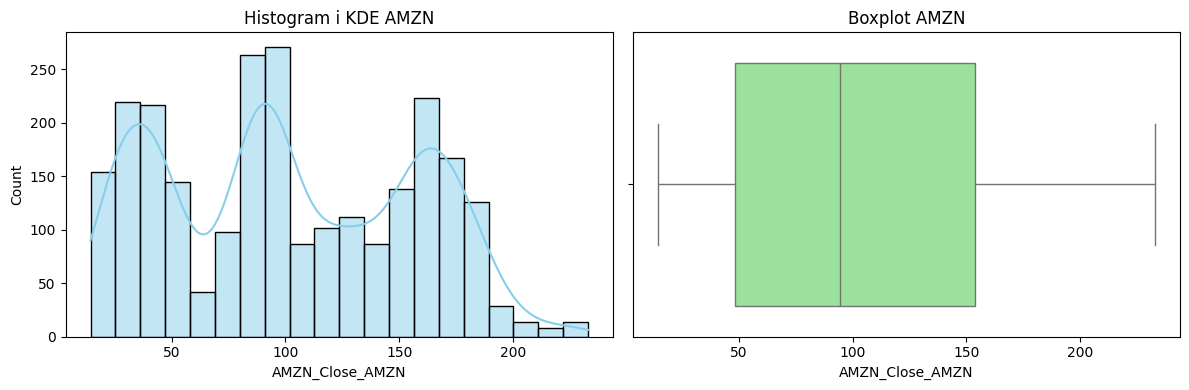

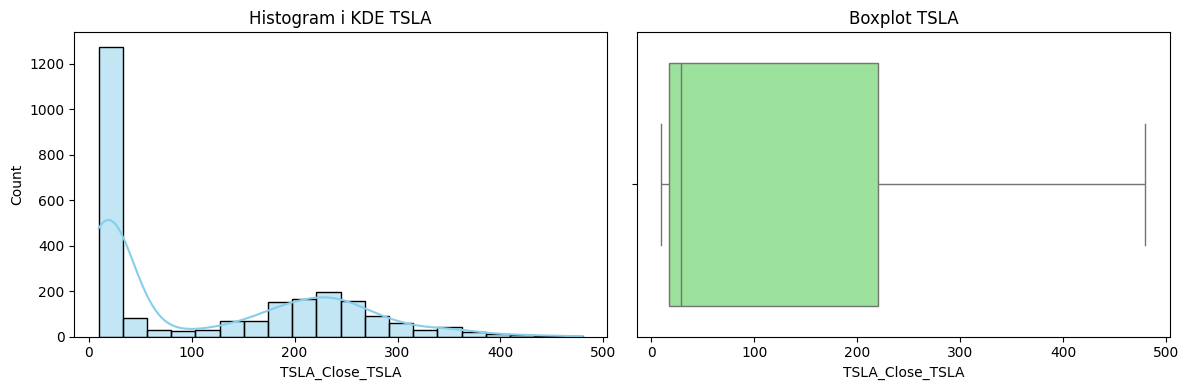

In [120]:
for ticker, column_name in zip(tickers, data.columns):
    # analiza rozkładu
    series = data[column_name]
    
    plt.figure(figsize=(12, 4))
    
    # Histogram + KDE
    plt.subplot(1, 2, 1)
    sns.histplot(series, kde=True, bins=20, color='skyblue')
    plt.title(f"Histogram i KDE {ticker}")
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=series, color='lightgreen')
    plt.title(f"Boxplot {ticker}")
    
    plt.tight_layout()
    plt.show()

In [121]:
# test statystyczny normalnosci
for ticker, column_name in zip(tickers, data.columns):
    # analiza rozkładu
    print(ticker)
    print("----")
    series = data[column_name]
    stat, p = shapiro(series)
    print(f"Test Shapiro-Wilka:")
    print(f"Statystyka: {stat:.4f}, p-wartość: {p:.4f}")
    if p > 0.05:
        print("Rozkład wygląda na normalny.")
    else:
        print("Rozkład różni się od normalnego.")
        print("\n")

AAPL
----
Test Shapiro-Wilka:
Statystyka: 0.8726, p-wartość: 0.0000
Rozkład różni się od normalnego.


MSFT
----
Test Shapiro-Wilka:
Statystyka: 0.9041, p-wartość: 0.0000
Rozkład różni się od normalnego.


GOOG
----
Test Shapiro-Wilka:
Statystyka: 0.9109, p-wartość: 0.0000
Rozkład różni się od normalnego.


NFLX
----
Test Shapiro-Wilka:
Statystyka: 0.9554, p-wartość: 0.0000
Rozkład różni się od normalnego.


AMZN
----
Test Shapiro-Wilka:
Statystyka: 0.9479, p-wartość: 0.0000
Rozkład różni się od normalnego.


TSLA
----
Test Shapiro-Wilka:
Statystyka: 0.8085, p-wartość: 0.0000
Rozkład różni się od normalnego.




In [122]:
# podstawowe statystyki opisowe
for ticker, column_name in zip(tickers, data.columns):
    # analiza rozkładu
    print(ticker)
    print("-----")
    series = data[column_name]
    print("Podstawowe statystyki:")
    print("\nSkośność:", skew(series))
    print("Kurtoza:", kurtosis(series))
    print("\n")


AAPL
-----
Podstawowe statystyki:

Skośność: 0.5027483609746528
Kurtoza: -1.1439663855815099


MSFT
-----
Podstawowe statystyki:

Skośność: 0.5401141995839315
Kurtoza: -0.9380314958524503


GOOG
-----
Podstawowe statystyki:

Skośność: 0.6168124472771226
Kurtoza: -0.8335487097738024


NFLX
-----
Podstawowe statystyki:

Skośność: 0.49364982431782584
Kurtoza: -0.3186494781545184


AMZN
-----
Podstawowe statystyki:

Skośność: 0.13638371100276792
Kurtoza: -1.1547738701054253


TSLA
-----
Podstawowe statystyki:

Skośność: 0.6480100997470751
Kurtoza: -0.9535165049687029




In [123]:
# preprocessing for predictions

def create_lag_features(df, ticker, lags=3):
    for i in range(1, lags + 1):
        df[f'{ticker}_lag_{i}'] = df[f'{ticker}_Close'].shift(i)
    return df

for ticker in tickers:
    data = create_lag_features(u, ticker)
    pass

u.dropna(inplace=True)
u.head(n=20)


Price,AAPL_Close,MSFT_Close,GOOG_Close,NFLX_Close,AMZN_Close,TSLA_Close,AAPL_lag_1,AAPL_lag_2,AAPL_lag_3,MSFT_lag_1,...,GOOG_lag_3,NFLX_lag_1,NFLX_lag_2,NFLX_lag_3,AMZN_lag_1,AMZN_lag_2,AMZN_lag_3,TSLA_lag_1,TSLA_lag_2,TSLA_lag_3
Ticker,AAPL,MSFT,GOOG,NFLX,AMZN,TSLA,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-07,23.937569,39.545330,24.868610,46.742859,14.921000,14.063333,23.606558,23.604338,24.288576,39.049198,...,26.045294,46.501431,47.311428,49.848572,14.764500,15.109500,15.4260,14.085333,14.006000,14.620667
2015-01-08,24.857302,40.708679,24.947023,47.779999,15.023000,14.041333,23.937569,23.606558,23.604338,39.545330,...,25.502361,46.742859,46.501431,47.311428,14.921000,14.764500,15.1095,14.063333,14.085333,14.006000
2015-01-09,24.883966,40.366524,24.623947,47.041428,14.846500,13.777333,24.857302,23.937569,23.606558,40.708679,...,24.911289,47.779999,46.742859,46.501431,15.023000,14.921000,14.7645,14.041333,14.063333,14.085333
2015-01-12,24.270805,39.861824,24.444290,45.547142,14.570500,13.480667,24.883966,24.857302,23.937569,40.366524,...,24.868610,47.041428,47.779999,46.742859,14.846500,15.023000,14.9210,13.777333,14.041333,14.063333
2015-01-13,24.486301,39.656536,24.624441,46.255714,14.737000,13.616667,24.270805,24.883966,24.857302,39.861824,...,24.947023,45.547142,47.041428,47.779999,14.570500,14.846500,15.0230,13.480667,13.777333,14.041333
2015-01-14,24.392996,39.314384,24.857197,46.320000,14.663500,12.846000,24.486301,24.270805,24.883966,39.656536,...,24.623947,46.255714,45.547142,47.041428,14.737000,14.570500,14.8465,13.616667,13.480667,13.777333
2015-01-15,23.730961,38.903778,24.902855,46.251431,14.347500,12.791333,24.392996,24.486301,24.270805,39.314384,...,24.444290,46.320000,46.255714,45.547142,14.663500,14.737000,14.5705,12.846000,13.616667,13.480667
2015-01-16,23.546568,39.553890,25.215015,48.191429,14.537000,12.871333,23.730961,24.392996,24.486301,38.903778,...,24.624441,46.251431,46.320000,46.255714,14.347500,14.663500,14.7370,12.791333,12.846000,13.616667


AAPL
MAE: 14.28
RMSE: 24.23


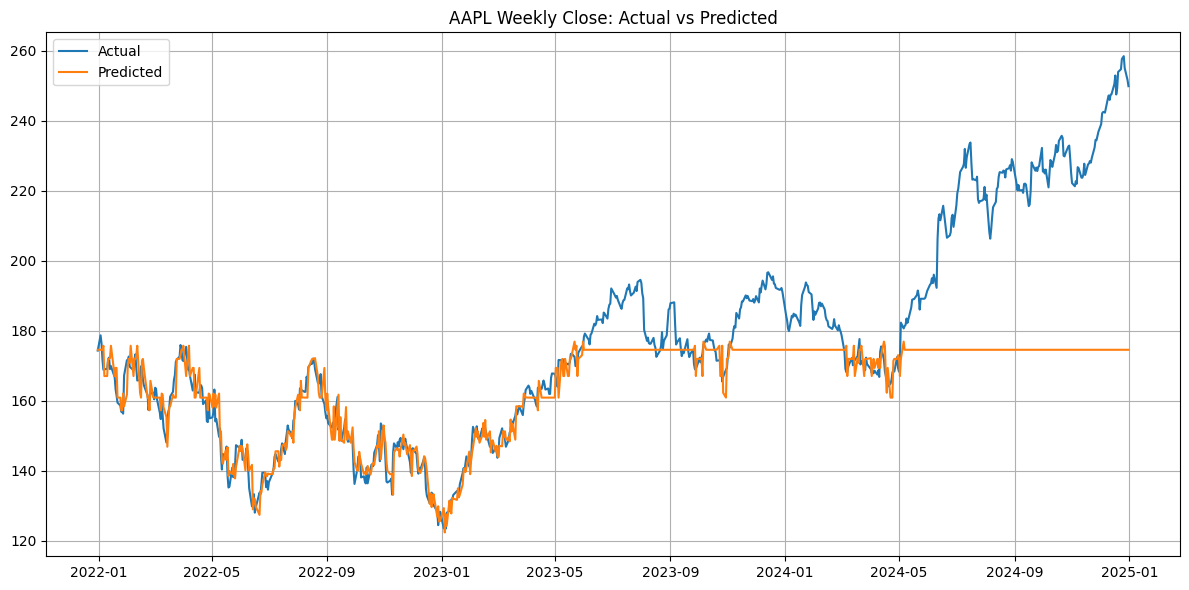

MSFT
MAE: 34.34
RMSE: 52.37


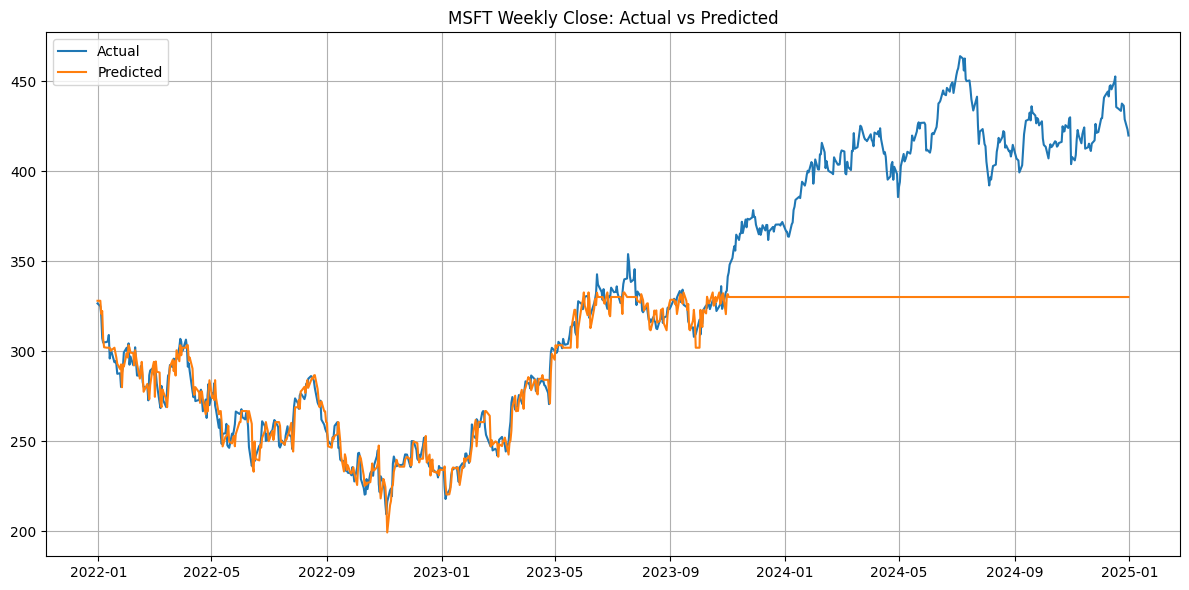

GOOG
MAE: 7.99
RMSE: 13.62


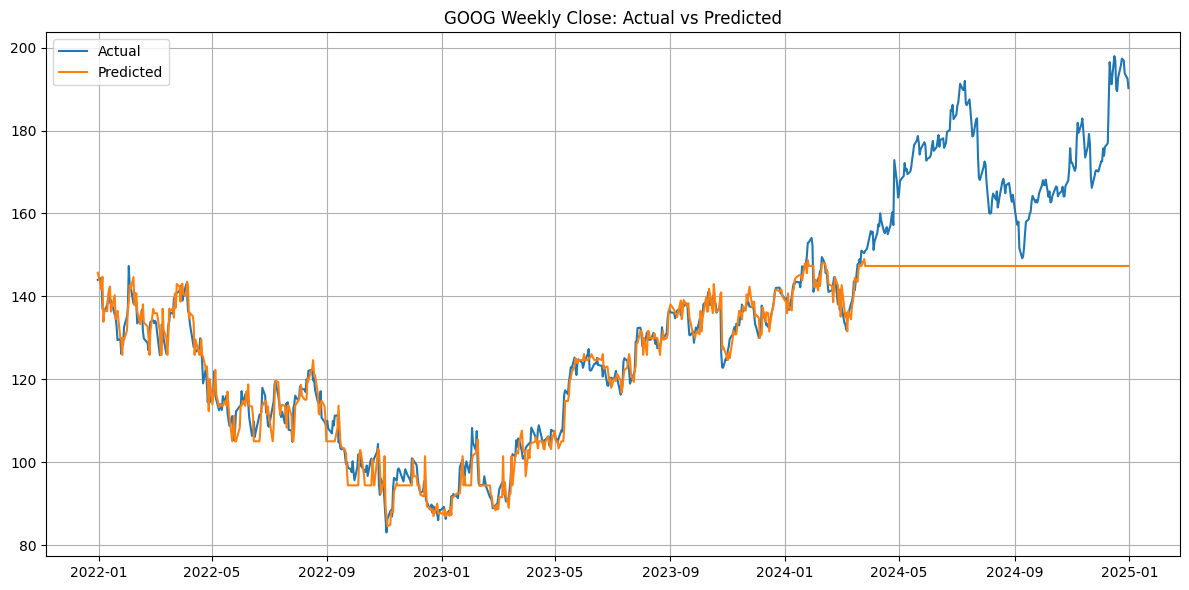

NFLX
MAE: 20.50
RMSE: 48.86


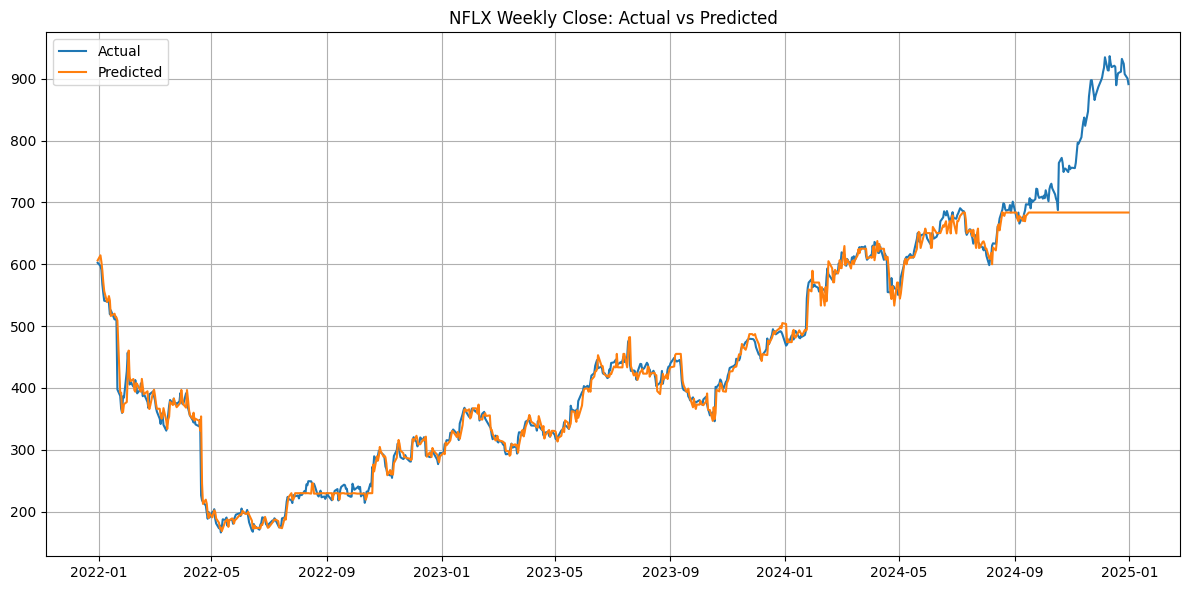

AMZN
MAE: 5.38
RMSE: 9.19


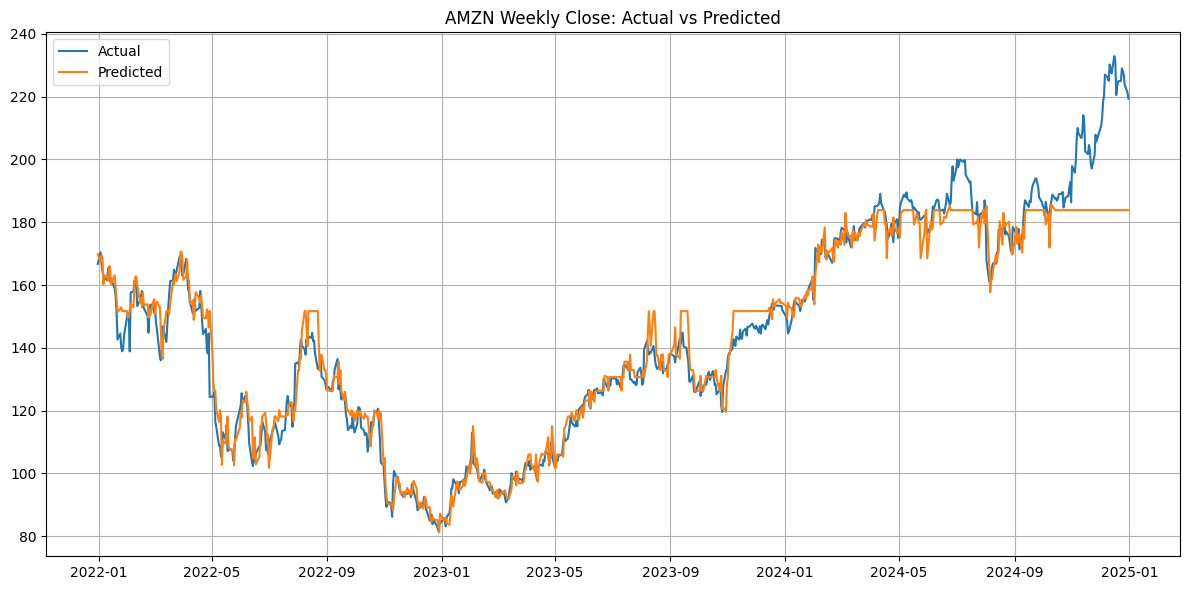

TSLA
MAE: 10.37
RMSE: 14.74


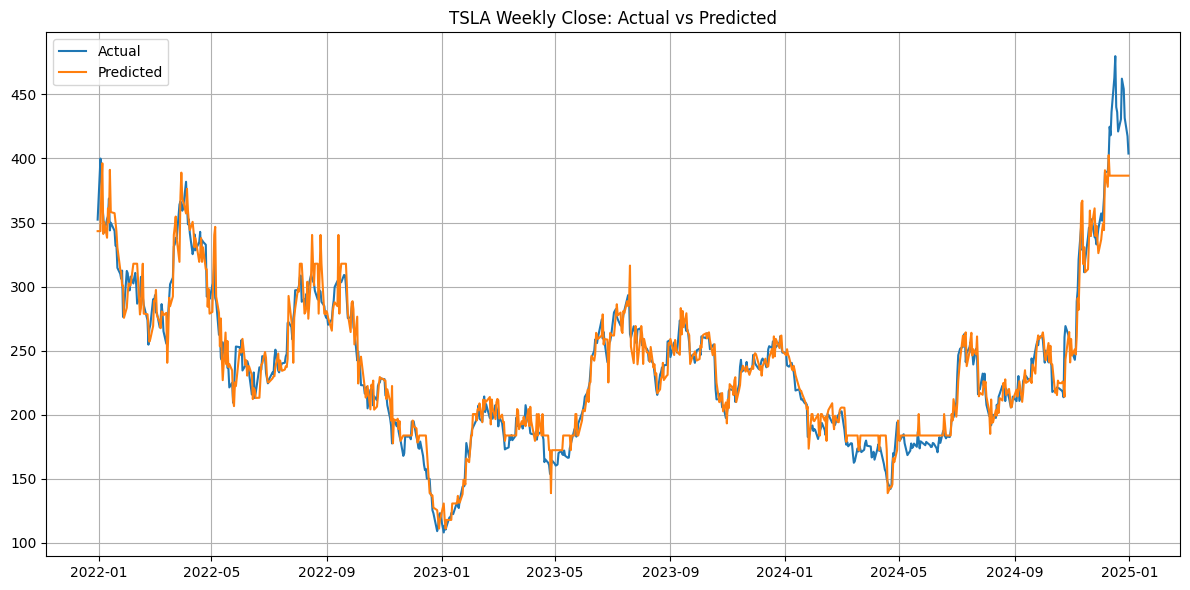

In [125]:
for ticker in tickers:
    print(ticker)

    target = f'{ticker}_Close'
    features = [f'{ticker}_lag_{i}' for i in range(1, 4)]
    
    X = u[features]
    y = u[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
    
    model = XGBRegressor()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, y_pred, label='Predicted')
    plt.title(f'{ticker} Weekly Close: Actual vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()